# Mayo Clinic - STRIP
### Image Classification of Stroke Blood Clot Origin
Image Segmentation (Work In Progress)


### Dataset Info:
The dataset for this competition comprises over a thousand high-resolution whole-slide digital pathology images. Each slide depicts a blood clot from a patient that had experienced an acute ischemic stroke.

The slides comprising the training and test sets depict clots with an etiology (that is, origin) known to be either CE (Cardioembolic) or LAA (Large Artery Atherosclerosis). We include a set of supplemental slides with a either an unknown etiology or an etiology other than CE or LAA.

Your task is to classify the etiology (CE or LAA) of the slides in the test set for each patient.

File and Data Field Descriptions
train/ - A folder containing images in the TIFF format to be used as training data.
test/ - A folder containing images to be used as test data. The actual test data comprises about 280 images.
other/ - A supplemental set of images with a either an unknown etiology or an etiology other than CE or LAA.
train.csv Contains annotations for images in the train/ folder.
image_id - A unique identifier for this instance having the form {patient_id}_{image_num}. Corresponds to the image {image_id}.tif.
center_id - Identifies the medical center where the slide was obtained.
patient_id - Identifies the patient from whom the slide was obtained.
image_num - Enumerates images of clots obtained from the same patient.
label - The etiology of the clot, either CE or LAA. This field is the classification target.
test.csv - Annotations for images in the test/ folder. Has the same fields as train.csv excluding label.
other.csv - Annotations for images in the other/ folder. Has the same fields as train.csv. The center_id is unavailable for these images however.
label - The etiology of the clot, either Unknown or Other.
other_specified - The specific etiology, when known, in case the etiology is labeled as Other.
sample_submission.csv - A sample submission file in the correct format. See the Evaluation page for more details. Note in particular that you should make one prediction per patient_id, not per image_id.


### Reading:
<a href="https://www.nature.com/articles/s41598-021-87584-2.pdf?origin=ppub">Scientific Report</a> | "First approach to distinguish between cardiac and arteriosclerotic emboli of individual stroke patients applying the histological THROMBEX‑classification rule"

<a href="https://www.nature.com/articles/srep42964">Scientific Report</a> | "Image processing in digital pathology: an opportunity to solve inter-batch variability of immunohistochemical staining"


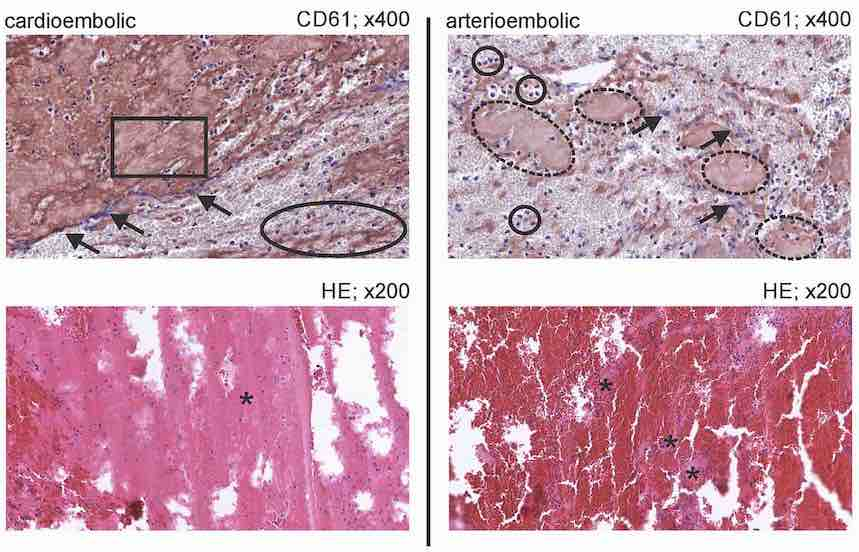

Histological presentation of typical cardioembolic and arterioembolic clots. For the two preparations immunohistochemical staining with CD61 (400-fold original magnification) and hematoxylin–eosin staining (200-fold original magnification) were prepared. The cardioembolic clot (left side) is characterized by a large number of platelets. Their distribution pattern reminds of stratus (rectangle) and cirrus (oval) cloud formations. Many disintegrated neutrophil granulocytes can be seen (arrows). Fibrin net is dense (star). This corresponds to a separation thrombus. In contrast, the arterioembolic clot (right side) is marked by a small amount of platelets arranged like cumulus clouds (dashed ovals). Apart from some disintegrated neutrophils (arrows), many intact neutrophils can be found (circles). Fibrin net is fine to coarse (stars). It is therefore an agglutinative thrombus that presumably arose from the tail part of a mixed-thrombus. Both emboli were extracted from patients with a definite stroke etiology. - <a href="https://www.nature.com/articles/s41598-021-87584-2.pdf?origin=ppub">www.nature.com/scientificreports</a>

### Notebook Goals:
* Look at image metadata from provided csv
* Open/read large tiff and reduce image size
* Segment images into patches of interest
* View hi-res patches
* Separate immunohistochemical staining (Convert color RGB to HED)

### Import Libraries

In [4]:
! pip install imutils

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import pandas as pd
import cv2 as cv
from imutils import paths
import skimage
from skimage.filters import sobel
from skimage import segmentation
from skimage.color import label2rgb
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity

from skimage.measure import regionprops, regionprops_table
from scipy import ndimage as ndi


import tifffile as tifi

from sklearn.preprocessing import StandardScaler

### Load Image Metadata

#### train.csv

In [6]:
train_meta = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
train_meta.head()

In [7]:
train_meta.info()

In [8]:
train_meta.label.value_counts()

#### test.csv

In [9]:
test_meta = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
test_meta.head()

In [10]:
test_meta.info()

#### other.csv

In [11]:
other_meta = pd.read_csv('../input/mayo-clinic-strip-ai/other.csv')
other_meta.head()

In [12]:
other_meta.info()

In [13]:
other_meta.label.value_counts()

In [14]:
other_meta.other_specified.value_counts()

## Explore Image Data

#### train folder images

In [15]:
folder_path = '../input/mayo-clinic-strip-ai/train'
train_images = sorted(list(paths.list_images(folder_path)))
print('There are ' + str(len(train_images)) + " images in the train folder")
train_images[:5]

In [16]:
image_ids = [i.split("/")[-1].rstrip('.tif') for i in train_images]
image_ids[:5]

#### test folder images

In [17]:
folder_path = '../input/mayo-clinic-strip-ai/test'
test_images = sorted(list(paths.list_images(folder_path)))
print('There are ' + str(len(test_images)) + " images in the test folder")
test_images

#### other folder images

In [18]:
folder_path = '../input/mayo-clinic-strip-ai/other'
other_images = sorted(list(paths.list_images(folder_path)))
print('There are ' + str(len(other_images)) + " images in the other folder")
other_images[:5]

### Open images
Read large tiff files using tifffile, return np.array and filename (image_id)

In [19]:
def read_tiff(path):
    image = tifi.imread(path)
    filename = path.split('/')[-1].rstrip('.tif')
    print("image_id: " + filename)
    return image, filename

In [21]:
image, filename = read_tiff(train_images[15])

In [22]:
image.shape

#### Resize images
Downsize images significantly before segmenting

In [23]:
def resize_image(image):
    re_sized_image = cv.resize(image,(int(image.shape[1]/33),int(image.shape[0]/33)),interpolation= cv.INTER_LINEAR)
    return re_sized_image

In [24]:
re_sized_image = resize_image(image)

In [25]:
re_sized_image.shape

#### Convert to Grayscale

In [26]:
def convert_image_grayscale(image):
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    return gray_image

In [29]:
resized_gray_img = convert_image_grayscale(re_sized_image)

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(resized_gray_img, cmap='gray')
plt.show()

#### Image Segmentation
##### Label Segments
Let's find the edges in the image using the Sobel filter. All images appear to be high key, we'll mark areas in the image that we don't want to keep (areas that are greater than or equal to the mean) with 1 and areas that we want to keep (less than the mean) with 2. Then we'll use a watershed to get a labeled matrix from the elevation map (Sobel filter) and markers array. Lastly we fill the holes in segments and return an array of labeled segments.

In [35]:
def segment_images(resized_gray_img):
    elevation_map = sobel(resized_gray_img) # creates image (array) that emphasizes edges
    markers = np.zeros_like(resized_gray_img) # array of zeros in the same shape as the resized_gray_img array
    markers[resized_gray_img >= resized_gray_img.mean()] = 1
    markers[resized_gray_img < resized_gray_img.mean()] = 2
    segmented_img = segmentation.watershed(elevation_map, markers) # distinguishes objects in image 
    filled_segments = ndi.binary_fill_holes(segmented_img - 1) # method works with 0s and 1s (hence the -1, now 1 = area to keep). If 0 is eclosed by 1s -> 0 converted to 1
    labeled_segments, _ = ndi.label(filled_segments) # labels features in array, where non-zero values in input = features, and zero values = background.
    return labeled_segments

In [36]:
labeled_segments = segment_images(resized_gray_img)

In [33]:
def plot_labeled_segments(labeled_segments, resized_gray_img):
    image_label_overlay = label2rgb(labeled_segments, image=resized_gray_img, bg_label=0) # Returns an RGB image where color-coded labels are painted over the image.
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title('segmentation')
    ax.imshow(image_label_overlay, cmap=plt.cm.gray) 
    ax.axis('off')

In [37]:
plot_labeled_segments(labeled_segments, resized_gray_img)

##### Object Coordinates
Let's get the coordinates (bounding box) and area for all labeled segments using regionprops_table. We'll scale the segment areas using StadardScaler and keep only those scaled areas greater than or equal to .75

In [38]:
def get_object_coordinates(labeled_segments):
    properties =['area','bbox','convex_area','bbox_area', 'major_axis_length', 'minor_axis_length', 'eccentricity']
    df = pd.DataFrame(regionprops_table(labeled_segments, properties=properties))
    standard_scaler = StandardScaler()
    scaled_area = standard_scaler.fit_transform(df.area.values.reshape(-1,1))
    df['scaled_area'] = scaled_area
    df.sort_values(by="scaled_area", ascending=False, inplace=True)
    objects = df[df['scaled_area']>=.75]
    display(objects.head())
    object_coordinates = [(row['bbox-0'],row['bbox-1'],row['bbox-2'],row['bbox-3'] )for index, row in objects.iterrows()]
    return object_coordinates

In [39]:
object_coordinates = get_object_coordinates(labeled_segments)

Let's plot the resized rgb image with bounding boxes surrounding areas of interest

In [40]:
def plot_object_coordinates(object_coordinates, re_sized_image):
    fig, ax = plt.subplots(1,1, figsize=(18, 16), dpi = 80)
    for blob in object_coordinates:
        width = blob[3] - blob[1]
        height = blob[2] - blob[0]
        patch = Rectangle((blob[1],blob[0]), width, height, edgecolor='r', facecolor='none')
        ax.add_patch(patch)
        ax.imshow(re_sized_image);
        ax.set_axis_off()

In [41]:
plot_object_coordinates(object_coordinates, re_sized_image)

Let's plot each object (area of interest) on a subplot

In [42]:
def plot_objects(object_coordinates, image):
    plt.figure(figsize=(10,18))
    for i in range(len(object_coordinates)):
        ax = plt.subplot(int(np.ceil(len(object_coordinates)/3)),3,i+1)
        coordinates = object_coordinates[i]
        # print(coordinates)
        object_image = image[int(coordinates[0]):int(coordinates[2]), int(coordinates[1]):int(coordinates[3])]
        plt.imshow(object_image)
        ax.axis('off')
    plt.show()
        

In [43]:
plot_objects(object_coordinates, re_sized_image)

Let's normalize the image coordinates from the resized image so they can be rescaled to original tiff dimensions then return a dictionary of patches (image_id, image_id + patch number, normalized coordinates, and rescaled coordinates).

In [44]:
def rescale_coordinates(object_location, image):
    top, bottom, left, right = object_location
    left = int(left * image.shape[0])
    bottom = int(bottom * image.shape[1])
    right = int(right * image.shape[0])
    top = int(top * image.shape[1])
    return top, bottom, left, right

def normalize_coordinates(object_coordinates, image):
    top, bottom, left, right = object_coordinates
    left = (int(left) / image.shape[0])
    bottom = (int(bottom) / image.shape[1])
    right = int(left) + (int(right) / image.shape[0])
    top = int(bottom) + (int(top) / image.shape[1])
    
    # object_location = top, bottom, left, right
    # top, bottom, left, right = rescale_coordinates(object_location, image)
    
    return top, bottom, left, right

def patches_dictionary(object_coordinates, re_sized_image, image, filename):
    patches = {}
    for i in range(len(object_coordinates)):
        coordinates = object_coordinates[i]
        normal_cords = normalize_coordinates(coordinates, re_sized_image)
        re_scaled_cords = rescale_coordinates(normal_cords, image)
        patches[str(filename)+"_"+str(i+1)] = [normal_cords, re_scaled_cords]
    patches = {filename:patches}
    return patches


In [45]:
patches = patches_dictionary(object_coordinates, re_sized_image, image, filename)
patches

Let's plot individual patches

In [46]:
def plot_patch(patch_name, cropped_image, cmap=None):
    plt.figure(figsize=(10,8), dpi=150)
    ax = plt.subplot()
    plt.imshow(cropped_image, cmap=cmap)
    ax.set_title(patch_name)
    ax.axis('off')
    plt.show()

def crop_patch(coordinates, image):
    x1, y1, x2, y2 = coordinates
    cropped_image = image[x1:x2, y1:y2]
    return cropped_image

In [47]:
# Read image metadata
train_meta[train_meta['image_id']==filename]


In [48]:
patch_name = str(filename)+"_"+str(1)
coordinates = patches[filename][patch_name][1]
cropped_image = crop_patch(coordinates, image)
plot_patch(patch_name, cropped_image)

### Simplify process
Run above in combined function

In [49]:
def process_image(path):
    image, filename = read_tiff(path)
    re_sized_image = resize_image(image)
    resized_gray_img = convert_image_grayscale(re_sized_image)
    labeled_segments = segment_images(resized_gray_img)
    plot_labeled_segments(labeled_segments, resized_gray_img)
    object_coordinates = get_object_coordinates(labeled_segments)
    patches = patches_dictionary(object_coordinates, re_sized_image, image, filename)
    print(str(len(patches[filename]))+" patches")
    cropped_images = []
    for i in range(len(patches[filename])):
        patch_name = str(filename)+"_"+str(i+1)
        coordinates = patches[filename][patch_name][1]
        cropped_image = crop_patch(coordinates, image)
        cropped_images.append([patch_name,cropped_image])
    return patches, cropped_images, filename

patches, cropped_images, filename = process_image(train_images[15])

In [50]:
# Display individual patches
patch_number = 5
image_meta = train_meta[train_meta.image_id==filename]
patch_name = str(filename)+"_"+str(patch_number)
patch = cropped_images[patch_number-1][1]
display(image_meta)
plot_patch(patch_name, patch)


### Individual patch experimenting with color conversions...

#### Convert patch color RGB to HED
Separate immunohistochemical (ihc) staining

In [51]:
# Convert rgb2hed
ihc_hed = rgb2hed(patch)

In [52]:
# Separate hed channels
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

Plot separated stainings (Hematoxylin, Eosin, DAB)

In [53]:
fig, axes = plt.subplots(1,4,figsize=(10,8),sharex=True,sharey=True)
ax = axes.ravel()
ax[0].imshow(patch)
ax[0].set_title("Original image")
ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin")
ax[2].imshow(ihc_e)
ax[2].set_title("Eosin")
ax[3].imshow(ihc_d)
ax[3].set_title("DAB")
for a in ax.ravel():
    a.axis('off')
fig.tight_layout()

In [54]:
# Rescale hematoxylin and DAB channels and give them a fluorescence look
h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 0], 95)))
d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 2], 95)))

# Cast the two channels into an RGB image, as the blue and green channels
# respectively
zdh = np.dstack((null, d, h))


In [55]:
plt.figure(figsize=(10,8))
ax = plt.subplot()
plt.imshow(zdh)
plt.title('Stain-separated image (rescaled)')
ax.axis('off')
plt.show()